In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os 
import numpy as np
from mindreadingautobots.sequence_generators import make_datasets, data_io
import matplotlib.pyplot as plt
import time

In [3]:
# # Generate data with bitflip values
# n_val = 10000 # number of validation examples
# seed = 1234
# n_data = 1000000
# n_bits = 16 # number of TOTAL bits
# # variables
# # p_bitflips = [0, 0.05, 0.1]
# # p_bitflips = [0.15]
# p_bitflips = [0.2]

# def hamilton_6_choose_4(n_data, n_bits, p_bitflip, seed):
#     return make_datasets.k_choose_m_hamilton_forecast_dataset(k=6, m=4, n_data=n_data, n_bits=n_bits, p_bitflip=p_bitflip, seed=seed)


# X, Z, idx = hamilton_6_choose_4(n_data, n_bits, p_bitflips[0], seed)

In [85]:
def xlogx(x):
    return x * np.log2(x) if x > 0 else 0

def empirical_entropy_estimate(X, intermediate_idx=[-1]):
    """Construct an empirical estimator for the entropy H(X_n|X^{n-1})
    
    This is based purely on an empirical estimate for p_{X_n|X^{n-1}}.
    Thus, at the same time we can approximate the optimal success
    probability for the next bit.

    Returns:
        - entropy_out: entropy estimate for the next bit
        - mle_out: maximum likelihood success probability for the next bit
    """
    # n_data, n_bits = X.shape

    entropy_out = [] # entropy estimate for the next bit
    mle_out = [] # maximum likelihood estimate for the next bit
    lb = 0
    current_total = 0
    # These dicts represent histograms for empirical distribution of X^n and X^{n-1}
    dct_n = {}
    dct_nminus1 = {}
    keys_n = []
    keys_nminus1 = []

    # This will iterate over smaller subsets of data.
    # print("1")
    # print(intermediate_idx)
    for i in intermediate_idx:
        current_bounds = [lb, i]
        keys_n_new, counts_n = np.unique(X[lb:i,:], axis=0, return_counts=True)
        keys_nminus1_new = np.unique(keys_n_new[:, :-1], axis=0)
        # cast to normal ints.
        keys_n_new = [list([int(x) for x in k]) for k in keys_n_new]
        keys_nminus1_new = [list([int(x) for x in k]) for k in keys_nminus1_new]
        # keep track of the new total data
        slc_n = sum(counts_n)
        current_total += slc_n
        keys_n = list(set(keys_n + [tuple(k) for k in keys_n_new]))
        keys_nminus1 = list(set(keys_nminus1 + [tuple(k) for k in keys_nminus1_new]))

        for k, v in zip(keys_n_new, counts_n):
            if tuple(k) not in dct_n:
                dct_n[tuple(k)] = 0
            dct_n[tuple(k)] += v

            if tuple(k[:-1]) not in dct_nminus1:
                dct_nminus1[tuple(k[:-1])] = 0
            dct_nminus1[tuple(k[:-1])] += v

        # estimate entropy from histograms
        H_Xn = 0
        for k, v in dct_n.items():
            p = v / current_total
            H_Xn -= xlogx(p)
        
        H_Xnminus1 = 0
        mle = 0
        for k in keys_nminus1:
            # entropy calculation: H(X^{n-1})
            p = dct_nminus1[k] / current_total # = p_{X^{n-1}}(x^{n-1})
            H_Xnminus1 -= xlogx(p)
            # MLE calculation: Find out whether p_{X_n|X^{n-1}}(0|x^{n-1}) > p_{X_n|X^{n-1}}(1|x^{n-1})
            pr_xnminus1_and_0 = dct_n.get(tuple(list(k)+[0])) 
            pr_xnminus1_and_1 = dct_n.get(tuple(list(k)+[1]))
            # print(k)
            # print(dct_n.keys())
            # print(tuple(list(k)+[0]))
            # print("pr_xnminus1_and_0: ", pr_xnminus1_and_0)
            # print("pr_xnminus1_and_1: ", pr_xnminus1_and_1)
            
            if pr_xnminus1_and_0 is not None:
                pr_xnminus1_and_0 = pr_xnminus1_and_0 / current_total
                # This condition is equivalent to the conditional distirbution being > 0.5
                if pr_xnminus1_and_0 > 0.5 * p:
                    mle += pr_xnminus1_and_0
                else:
                    mle += p - pr_xnminus1_and_0
            else: # logically, this other entry must be present
                mle += pr_xnminus1_and_1  / current_total

        # print(mle)
        mle_out.append(mle)
        entropy_out.append(H_Xn - H_Xnminus1)
        lb = i

    return entropy_out, mle_out


In [86]:
# Create a different dataset for every 'nondeterministic' value in this list
# Note that _sometimes_ this means bitflip rate, but not always
p_bitflips = [0.0, 0.1]
# p_bitflips = [0]

inc = 500 # increment at which to check convergence
# Generate data with bitflip values
seed = 1234 
n_data = int(1e4)
n_bits = 16 
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle = []
for i in range(len(p_bitflips)):
    print("computing for p_bitflip = ", p_bitflips[i])
    X, Z, idx = make_datasets.k_choose_m_hamilton_forecast_dataset(6, 4, n_data, n_bits, p_bitflips[i], seed)
    H_results, mle_results = empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    all_H.append(H_results)
    all_mle.append(mle_results)



computing for p_bitflip =  0.0
computing for p_bitflip =  0.1


In [32]:
inc = 50000 # increment at which to check convergence
# Generate data with bitflip values
seed = 1234 
n_data = int(65)
n_bits = 16 
intermediate_idx = list(range(inc, n_data, inc))

X, Z, idx = make_datasets.k_choose_m_hamilton_forecast_dataset(6, 4, n_data, n_bits, 0.0, seed)

Hvals, mle_vals = empirical_entropy_estimate(Z, intermediate_idx=[-1])

1
[-1]
2
{(0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1): np.int64(1), (0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1): np.int64(1), (0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1): np.int64(1), (0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0): np.int64(2), (0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0): np.int64(1), (0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1): np.int64(1), (0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0): np.int64(1), (0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0): np.int64(3), (0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1): np.int64(3), (0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0): np.int64(1), (0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1): np.int64(1), (0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1): np.int64(2), (0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1): np.int64(2), (0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0): np.int64(2), (0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1): np.int64(1), (0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0): np.int64(1), (0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [100]:
def h2_inverse(y):
    return 0.5 * (1 - np.sqrt(1 - y ** (4/3)))

def plot_entropy_and_convergence(all_H, all_mle, p_bitflips, intermediate_idx, fano=False):

    fig, ax = plt.subplots()
    final_H = [H[-1] for H in all_H]
    final_mle = [mle[-1] for mle in all_mle]
    if fano:
        ax.plot(p_bitflips, 1 - h2_inverse(np.array(final_H)), label='Fano bound')
    ax.plot(p_bitflips, np.array(final_mle), label='MLE', linestyle='-', marker='o')
    ax.set_ylim([.5, 1])
    ax.grid()
    ax.legend()
    ax.set_xlabel("Pr(bitflip)")
    print(final_mle)

    # plot convergences
    fig, axes = plt.subplots(1, len(p_bitflips), figsize=(10, 4))
    if len(p_bitflips) == 1:
        axes = [axes]
    for i, (H_results, mle_results) in enumerate(zip(all_H, all_mle)):
        ax = axes[i]
        ax.plot(intermediate_idx,  np.array(H_results), label='entropy convergence')
        ax.plot(intermediate_idx, np.array(mle_results), label='MLE convergence')
        ax.set_ylim([.5, 1])
        ax.grid()
        ax.legend()
        ax.set_title(f'p={p_bitflips[i]}')
        ax.set_xlabel('n_data')
        ax.semilogx()

Fano's inequality, in this setting, is 
$$
H(X_n|Z^{n-1}) \leq h_2 (p_{err}) + p_{err}\log_2(N - 1) = h_2 (p_{err})
$$
Since $h_2$ is monotonic increasing, then so is $h_2^{-1}$, leading us to the inequality
$$
(1 - p_{err}) = p^* \leq 1 - h_2^{-1}(H(X_n|Z^{n-1}) )
$$
where $p^*$ is the success probability. We plot this upper bound below.

**Idea**: I think the post-hoc code tells us that as $n$ gets larger and larger, the success rate here should (??) approach capacity of the channel?

### (k=4, n=10) sparse parity analysis

[np.float64(0.9613273684210533), np.float64(0.7047463157894737), np.float64(0.5639978947368427)]


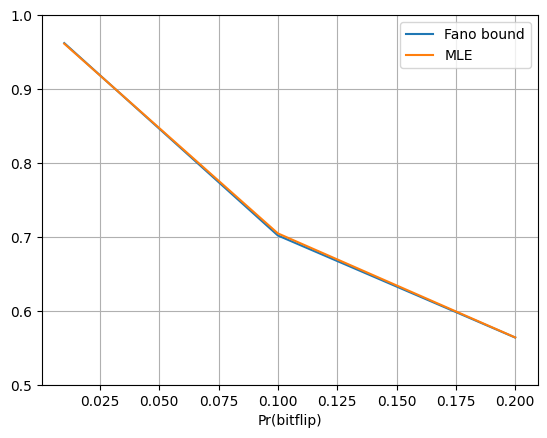

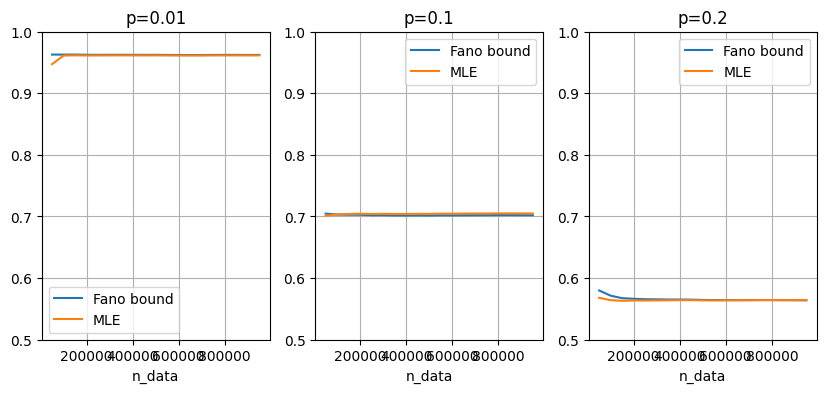

In [6]:
# Create a different dataset for every 'nondeterministic' value in this list
# Note that _sometimes_ this means bitflip rate, but not always
p_bitflips = [0.01, 0.1, 0.2]
all_H = []
all_mle = []

inc = 50000 # increment at which to check convergence
# Generate data with bitflip values
seed = 1234 
n_data = 1000000
n_bits = 10 
intermediate_idx = list(range(inc, n_data, inc))

for i in range(len(p_bitflips)):
    X, Z, idx = make_datasets.sparity_k4(n_data, n_bits, p_bitflips[i], seed)
    H_results, mle_results = empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    all_H.append(H_results)
    all_mle.append(mle_results)


[np.float64(0.9613273684210533), np.float64(0.7047463157894737), np.float64(0.5639978947368427)]


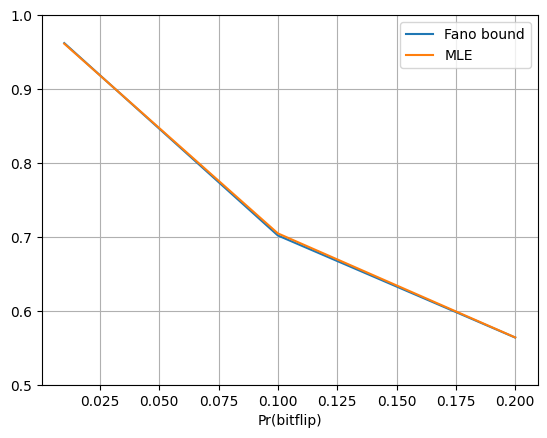

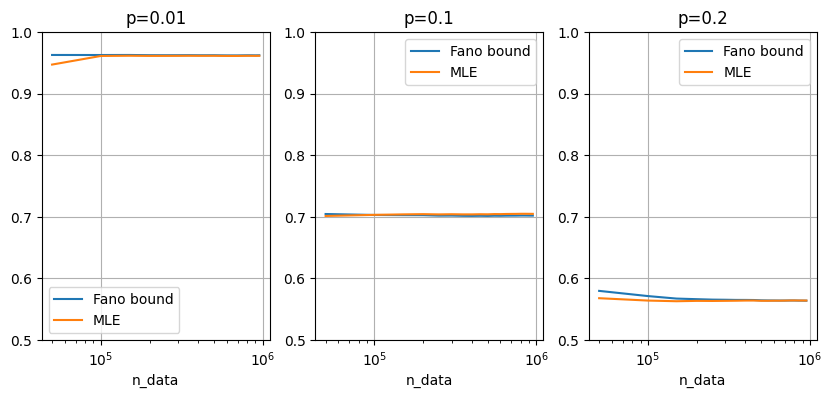

In [8]:
plot_entropy_and_convergence(all_H, all_mle, p_bitflips, intermediate_idx)

### Hamilton data

In [96]:
# Create a different dataset for every 'nondeterministic' value in this list
# Note that _sometimes_ this means bitflip rate, but not always
p_bitflips = [0.0, 0.1, 0.2]
# p_bitflips = [0]

inc = 50000 # increment at which to check convergence
# Generate data with bitflip values
seed = 1234 
n_data = int(1e7)
n_bits = 16 
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = make_datasets.k_choose_m_hamilton_forecast_dataset(6, 4, n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    H_results, mle_results = empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle.append(mle_results)


generated data for p_bitflip =  0.0  took  14.850996971130371
computed entropy for p_bitflip =  0.0  took  45.28820085525513
generated data for p_bitflip =  0.1  took  63.212958097457886
computed entropy for p_bitflip =  0.1  took  131.77833938598633
generated data for p_bitflip =  0.2  took  148.4183008670807
computed entropy for p_bitflip =  0.2  took  168.53839468955994


[np.float64(1.0), np.float64(0.9313474371859811), np.float64(0.7745326633165825)]


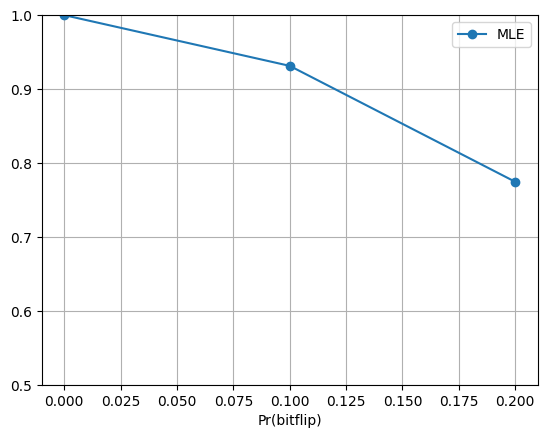

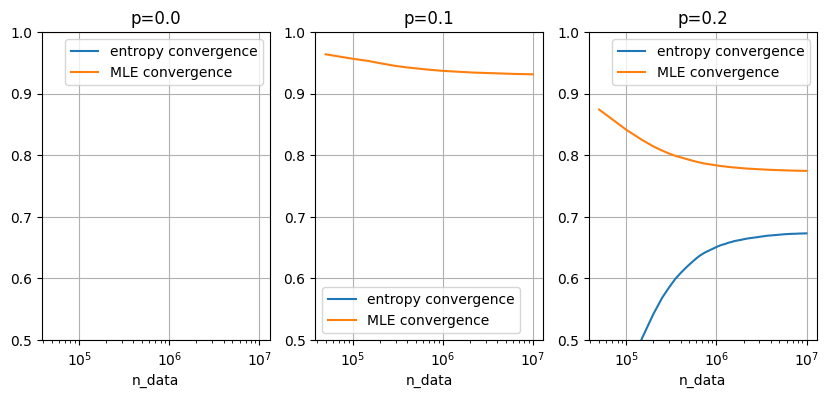

In [101]:
plot_entropy_and_convergence(all_H, all_mle, p_bitflips, intermediate_idx)